# Phenometrics: A Field Report based on Planetery Variables
Understanding vegetation dynamics and phenological patterns is essential for effective agricultural management, ecosystem monitoring, and sustainability planning.<br>
By calculating **vegetation metrics** (such as start, peak, and end of growing seasons) and **climatic metrics** (based on land surface temperature and soil moisture), we can gain insights into how plants respond to environmental conditions throughout the growing cycle. 

### Why extracting metrics
These metrics offer a detailed snapshot of the growing season and are critical for understanding crop health, productivity, and environmental interactions. Here’s a breakdown of the importance of each type:

##### 1. Seasonal Timing and Duration
   - **Start and End Dates**: These mark the overall season's duration and help in aligning management practices with the growth timeline.
   - **Duration**: The length of the season indicates crop growth resilience and environmental adaptability.
   - **Crop Season Length and Time to Peak**: Knowing the time required to reach peak growth helps in planning interventions and yield predictions.

##### 2. Vegetation Health and Dynamics
   - **Total Season Magnitude**: This metric shows the net change in vegetation index over the season, indicating overall crop health or stress.
   - **Peak Date and Peak Value**: Peak growth timing and intensity are crucial for evaluating maximum biomass production.
   - **Greenup and Senescence Dates, Duration, and Rates**: Midpoints and durations of green-up and senescence phases, along with greening and senescence rates, reveal how quickly vegetation matures and declines, informing nutrient and irrigation needs.

##### 3. Productivity and Accumulation Metrics
   - **Total Integrated Values**: These values represent cumulative vegetation activity, useful for understanding photosynthetic efficiency and yield potential.
   - **Dips**: Occasional dips provide insights into stress periods, likely linked to adverse weather or water stress.

##### 4. Climatic Factors
   - **Temperature and Soil Water Content at Peak Growth**: These values indicate the ideal temperature and moisture conditions supporting peak growth, aiding in identifying the optimal conditions for crop health.
   - **Growing Degree Days**: This accumulated heat metric measures how much warmth was available, guiding growth rate assessments and management practices.
   - **Soil Water Content Deficit Periods**: Absence or presence of deficit periods indicates drought or water scarcity, critical for irrigation planning.

##### 5. Environmental Interaction Metrics
   - **CB, LST and SWC Correlations**: Correlations with Land Surface Temperature and Soil Water Content help to assess environmental sensitivity, highlighting the crop’s response to heat and moisture levels.
   - **Moisture Sensitivity Index**: This value quantifies how responsive the crop is to moisture variations, useful for drought vulnerability assessments.
   - **Water Use Efficiency**: Efficiency metrics indicate how effectively the crop utilizes water resources for growth, crucial for sustainability assessments and resource management.

Together, these metrics provide a comprehensive picture of crop growth, climatic influence, and seasonal productivity, making them indispensable for data-driven agricultural management.<br>
This data allows you to offer detailed insights for decision-making at each growth stage and for improving yield forecasting, risk management, and sustainable practices.

### From Data to Action
In this analysis, we use **crop biomass** (derived from a Sentinel -1 and -2) alongside **land surface temperature** (LST) and **soil water content** (SWC) data.<br>
Crop biomass provides a proxy for vegetation health and productivity, while LST and soil moisture help capture the climatic and soil conditions that directly influence plant growth.<br>
Tracking these parameters allows us to quantify critical stages in the plant lifecycle (like green-up, peak growth, and senescence), assess the impact of temperature and moisture fluctuations on productivity, and detect stress conditions such as drought or heatwaves.<br>

By monitoring these metrics over time, we can identify trends in crop phenology, improve yield predictions, and support data-driven decisions to optimize resource use and mitigate adverse climate effects on crop growth.<br>

**Planetary Variables offers a unique dataset** because they are consitent and available globally, while they are produced daily independently of the cloud condition (less than 24h after the satellite's observation) with an archive of +5 years. 

### Overview
In this playbook, we combine several powerful tools to analyze agricultural fields over time:
1. Data Subcription: We use the subcription API to fetch the Planetary Variables data (Crop Biomass, Land Surface Temperature and Soil Water Content) for a specific field over a given time range.
2. Time Series Analysis: The script processes this data into a time series, allowing us to track changes over time. *Cloud storage is not required for time series subscriptions.*
3. Growing season Identification: Using a combination of these indices, we estimate the probability of bare soil for each data point.
4. Metrics calculation: The script calculates various metrics after explained above.
5. Visualization: The results are visualized in two graphs: one showing all indices over time, and another focusing specifically on bare soil probability.

## Before you start
To be able to run this code, you will need:
1. 🔑 A Planet API key. See: [Find Your API Key](https://developers.planet.com/quickstart/apis/#find-your-api-key)
2. 📦 A (virtual) environment with a recent (>= 3.8) Python installation and the following packages:
   - [Planet SDK for Python](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/get-started/quick-start-guide/#step-1-install-python-37-and-a-virtual-environment)
   - [matplotlib](https://matplotlib.org/)
   - [rich](https://rich.readthedocs.io/en/stable/introduction.html) - for fancy printing
3. 🌍 Access to the `BIOMASS-PROXY_V4.0_10`, `LST-AMSR2_V1.0_100`, `SWC-SMAP-L_V2.0_100` products.

Below you will find a workflow to subscribe and retrieve Crop Biomass, Land Surface Temperature, and Soil Water Content data. Since this notebook will focus on temporal data, the output will be in CSV format. For more elaborate explanations and examples, please see the [GitHub Subscriptions API Jupyter notebooks](https://github.com/planetlabs/notebooks/tree/master/jupyter-notebooks/Subscriptions-API). 

ℹ️ Install all the right packages in one go with the [environment YAML file](phenometrics_notebook_env.yml).

In [ ]:
import datetime as dt
from getpass import getpass
from rich import print
import pandas as pd
from io import StringIO
from planet import Auth, Session
from planet.clients.subscriptions import SubscriptionsClient
from planet.subscription_request import planetary_variable_source, build_request

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import simpson

### Credentials
The next step is to [authenticate with Planet services](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-guide/#authenticate-with-planet-services). When running the following code you will be prompted to enter your [Planet API Key](https://developers.planet.com/quickstart/apis/#find-your-api-key), which will be stored for making the subsequent calls to the Subscriptions API.

In [267]:
api_key = getpass('Enter your API key:')
auth = Auth.from_key(api_key)

### Creating your subscriptions and getting the uuids

For our analysis of the phenometrics, ee need to create three subscriptions, one for each product. <br>
1. `BIOMASS-PROXY_V4.0_10`
2. `LST-AMSR2_V1.0_100`
3. `SWC-SMAP-L_V2.0_100`

Asynchronous execution allows non-blocking operations, enabling other tasks to run concurrently while waiting for I/O-bound operations like network requests to complete.<br>
> The two functions below will be used to 
> 1) Create a subscription for a given source
> 2) Get the results of a subscription as a pandas DataFrame

In [268]:
async def create_subscription(
    subscription_name: str,
    pv_source: dict,
    auth: Auth,
):
    """
    Create a subscription for a given source without cloud delivery
    Rasters will not be delivered. Only time series data will be delivered.
    """
    # https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.subscription_request.build_request
    request = build_request(subscription_name, source=pv_source, delivery={},)

    # Create the subscription using the function create_subscription
    async with Session(auth=auth) as sess:
        cl = SubscriptionsClient(sess)
        # https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.create_subscription
        subscription_desc = await cl.create_subscription(request)
    print(f"{subscription_desc['id']} named {subscription_desc['name']} created")

    return subscription_desc


async def get_results_csv(subscription_id: str, auth: Auth):
    """
    Get the results of a subscription as a pandas DataFrame
    """
    async with Session(auth=auth) as sess:
        cl = SubscriptionsClient(sess)
        # https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.get_results_csv
        results = cl.get_results_csv(subscription_id=subscription_id)
        results_list = [i async for i in results]

    return pd.read_csv(StringIO("\n".join(results_list)), parse_dates=["item_datetime", "local_solar_time"], index_col="local_solar_time")

#### If you need to create susbcriptions
You need to request the data using the `create_subscription` function for each requested PVs. <br>
> ⚠️ **Warning:** Save the `uuid` for later. If you already have subscribed, do not request the data again.

In [211]:
# store the pv names and subscription ids in a dictionary
START_DATE = dt.datetime(2019, 1, 1)
END_DATE = dt.datetime(2024, 11, 1)
AOI = "pl:features/my/Yr0NRwv/0DaY2Lm" #using Planet Feature Manager: https://www.planet.com/features/
name = "trichetterie"

PVS = ['biomass_proxy', 'land_surface_temperature', 'soil_water_content']
PRODUCT_IDS = ['BIOMASS-PROXY_V4.0_10', 'LST-AMSR2_V1.0_100', 'SWC-SMAP-L_V2.0_100']

subs = {}
# PVs to request
for pv, product_id in zip(PVS, PRODUCT_IDS):
    pv_source = planetary_variable_source(var_type=pv,
                                        var_id=product_id,
                                        geometry=AOI,
                                        start_time=START_DATE,
                                        end_time=END_DATE)
    subscription_desc = await create_subscription(subscription_name=f"{pv}_{name}", pv_source=pv_source, auth=auth)
    subs[pv] = subscription_desc['id']

1137dfb4-6814-40d6-a5a4-9da7e1716390 named biomass_proxy_trichetterie created
094fdc41-96fc-4bc8-af0a-f0ef4e48f40d named land_surface_temperature_trichetterie created
67f16e77-cb99-42da-affe-f367db5a8d9f named soil_water_content_trichetterie created


#### If you already have the susbcriptions
You can add the uuid for each of the planetary variables (`BIOMASS-PROXY_V4.0_10`, `LST-AMSR2_V1.0_100`, `SWC-SMAP-L_V2.0_100`)

In [397]:
# if you have already created the subscriptions and only have the uuids, you can use the following dictionary
subs = {
        'biomass_proxy': '1137dfb4-6814-40d6-a5a4-9da7e1716390',
        'land_surface_temperature': '094fdc41-96fc-4bc8-af0a-f0ef4e48f40d',
        'soil_water_content': '67f16e77-cb99-42da-affe-f367db5a8d9f'
        }

### Retrieve the results and organise the DataFrame
Get the results of a subscription as a pandas DataFrame and merged the data with a daily steps.<br>
1. Daily biomass_proxy is already based a daily timestamp.
2. Daily soil_water_content (SWC) is gap filled with `ffill` and the time is converted to date (NB: SWC has one observation per day).
3. Daily land_surface_temperature (LST) is averaged based on 1.30 and 13.30 solar local time and converted from Kelvin to Degree Celcius (NB: LST has two observations per day).

In [ ]:
# store all subscriptions in a dictionary
dfs = {}
for pv, sub_id in subs.items():
    if sub_id.endswith('.csv'):
        dfs[pv] = pd.read_csv(sub_id, index_col="local_solar_time", parse_dates=True)
    else:
        dfs[pv] = await get_results_csv(subscription_id=sub_id, auth=auth)

data = dfs['biomass_proxy'][["CB.band-1.mean"]].rename(columns={"CB.band-1.mean": "crop_biomass"})
data['lst'] = dfs['land_surface_temperature']["lst.band-1.mean"].groupby(dfs['land_surface_temperature'].index.date).mean()-273.15
data['swc'] = dfs['soil_water_content']["swc.band-1.mean"].ffill().groupby(dfs['soil_water_content'].index.date).mean()

## We are ready to start

<Axes: ylabel='Crop Biomass'>

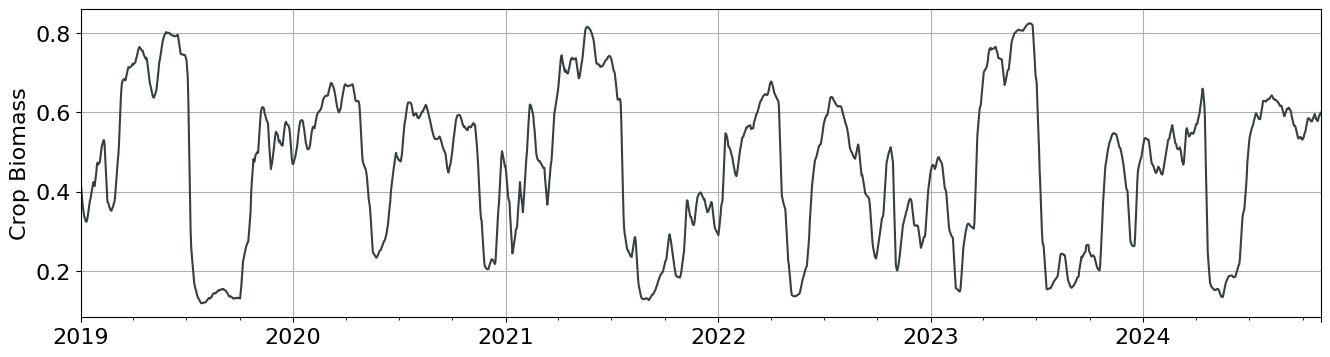

In [408]:
plt.rcParams.update({'font.size': 16})
data["crop_biomass"].plot(figsize=(16, 4), style="-", color="#363f43", grid=True, xlabel="", ylabel="Crop Biomass")

### Define the growing seasons
The start and end dates were added manually for this example. They are based on the user input for this playbook.

In [409]:
growing_seasons = [
        {'start_date': '2019-02-28', 'end_date': '2019-07-10'},
        {'start_date': '2019-10-16', 'end_date': '2020-05-16'},
        {'start_date': '2020-06-09', 'end_date': '2020-11-22'},
        {'start_date': '2021-01-12', 'end_date': '2021-07-27'},
        {'start_date': '2021-11-06', 'end_date': '2022-04-28'},
        {'start_date': '2022-06-06', 'end_date': '2022-09-23'},
        {'start_date': '2023-02-21', 'end_date': '2023-07-13'},
        {'start_date': '2023-10-22', 'end_date': '2024-04-23'},
    ]

### Display the growing seasons on the time serie

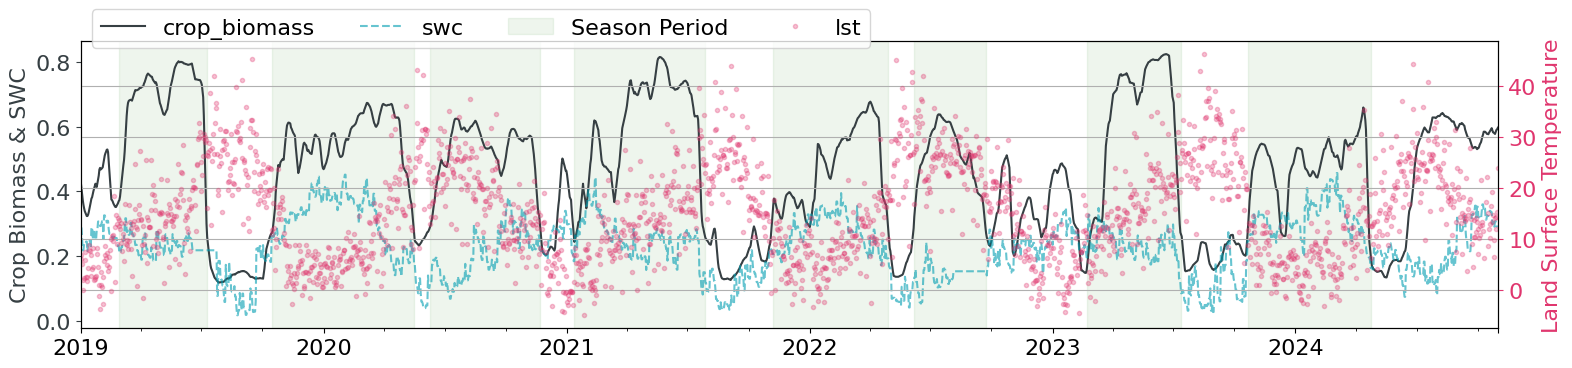

In [438]:
# Create the plot
fig, ax = plt.subplots(figsize=(16, 4))
plt.rcParams.update({'font.size': 16})

# Plot crop biomass
data["crop_biomass"].plot(ax=ax, style="-", color="#363f43", legend=False)

# Create a secondary y-axis for LST
ax1 = ax.twinx()
data["lst"].plot(ax=ax1, style=".", color="#E0366E", alpha=0.3, grid=True)

# Plot soil water content on the primary y-axis
data["swc"].plot(ax=ax, style="--", color="#009db1", alpha=0.6)

# Customize y-axis labels and ticks
ax.tick_params(axis='y', colors="#363f43", labelsize=16)
ax1.tick_params(axis='y', colors="#E0366E", labelsize=16)
ax.tick_params(axis='x', labelsize=16)

# Track labels to avoid duplicates
handled_labels = set()

# Highlight growing seasons
for growing_season in growing_seasons:
    start_of_season = pd.to_datetime(growing_season['start_date'])
    end_of_season = pd.to_datetime(growing_season['end_date'])

    label = 'Season Period'
    if label not in handled_labels:
        ax.axvspan(start_of_season, end_of_season, color="#59A14F", alpha=0.1, label=label)
        handled_labels.add(label)
    else:
        ax.axvspan(start_of_season, end_of_season, color="#59A14F", alpha=0.1)

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Crop Biomass & SWC', color="#363f43")
ax1.set_ylabel('Land Surface Temperature', color="#E0366E")

# Add legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0, 1.15), ncol=4)

plt.tight_layout()
plt.show()

### Calculating the metrics
Here's a brief explanation for each function below:

1. **`find_dips(growing_season, dip_threshold=0.1)`**  
   This function identifies significant dips in vegetation data within a growing season, helping detect potential disturbances by analyzing peak-to-valley transitions.

2. **`calculate_vegetation_metrics(series, dip_threshold=0.1)`**  
   Calculates key vegetation metrics within each growing season, including the peak and duration of the season, as well as mid-season growth and senescence rates.

3. **`calculate_climatic_metrics(series, lst_series, swc_series, base_temp=10, swc_deficit_threshold=0.15)`**  
   Computes climate-related metrics, including temperature, soil moisture at peak growth, and growing degree days, which influence vegetation growth.

4. **`analyze_growing_seasons(df, growing_seasons)`**  
   Analyzes each growing season by integrating vegetation and climate metrics, returning comprehensive reports for each season’s characteristics.

In [ ]:
# Function to find dips in the growing season: so-called "cereal dip"
def find_dips(growing_season, dip_threshold):
    growing_season = growing_season.rolling(window=4, center=True).mean()
    # Find peaks (local maxima)
    peaks, _ = find_peaks(growing_season)
    # Find valleys (local minima) by inverting the data
    valleys, _ = find_peaks(-growing_season)
    # Initialize list to store full dips
    dips = []
    # Find full dips from peak-to-valley-to-peak
    for valley in valleys:
        # Find the nearest previous peak
        previous_peaks = peaks[peaks < valley]
        next_peaks = peaks[peaks > valley]

        if len(previous_peaks) > 0 and len(next_peaks) > 0:
            # Get the closest previous and next peak around the valley
            start_peak = previous_peaks[-1]
            end_peak = next_peaks[0]

            # Calculate dip magnitude
            total_dip_magnitude1 = growing_season.iloc[start_peak] - growing_season.iloc[valley]
            total_dip_magnitude2 = growing_season.iloc[end_peak] - growing_season.iloc[valley]
            if min(total_dip_magnitude1, total_dip_magnitude2) > dip_threshold:
                dips.append({
                    "start_date": growing_season.index[start_peak].date(),
                    "valley_date": growing_season.index[valley].date(),
                    "end_date": growing_season.index[end_peak].date(),
                    "duration_days": (growing_season.index[end_peak] - growing_season.index[start_peak]).days,
                    "total_dip_magnitude": round(min(total_dip_magnitude1, total_dip_magnitude2), 2)
                })
    return dips

# Function to calculate vegetation metrics for each growing season
def calculate_vegetation_metrics(series, dip_threshold=0.05):
    metrics = {}
    dates = series.index

    # 1. Start of Season (SOS) and End of Season (EOS)
    metrics["start of season (value)"] = series.iloc[0]
    metrics["end of season (value)"] = series.iloc[-1]
    metrics["crop season length"] = (dates[-1] - dates[0]).days

    # Peak of Season (POS)
    peak_idx = np.argmax(series)
    metrics["peak date"] = dates[peak_idx]
    metrics["peak value"] = series.iloc[peak_idx]
    metrics["time to peak"] = (metrics["peak date"] - dates[0]).days

    # Mid-Greenup and Mid-Senescence Dates
    min_greenup_idx = np.argmin(series.iloc[:peak_idx])
    mid_greenup_ndvi = (series.iloc[min_greenup_idx] + metrics["peak value"]) / 2
    mid_greenup_idx = np.where(series.iloc[:peak_idx] >= mid_greenup_ndvi)[0][0]
    metrics["mid greenup date"] = dates[mid_greenup_idx]
    metrics["greenup duration"] = (dates[mid_greenup_idx] - dates[0]).days

    min_senescence_idx = np.argmin(series.iloc[peak_idx:-1]) + peak_idx
    mid_senescence_ndvi = (series.iloc[min_senescence_idx] + metrics["peak value"]) / 2
    mid_senescence_idx = np.where(series.iloc[peak_idx:] <= mid_senescence_ndvi)[0][0] + peak_idx
    metrics["mid senescence date"] = dates[mid_senescence_idx]
    metrics["senescence duration"] = (dates[-1] - dates[mid_senescence_idx]).days

    # Greening and Senescence Rates
    metrics["greening rate"] = (metrics["peak value"] - series.iloc[0]) / metrics["greenup duration"]
    metrics["senescence rate"] = (metrics["peak value"] - series.iloc[-1]) / metrics["senescence duration"]

   # Calculate TI CB beforeMax
    metrics["total integrated (before max)"] = series.iloc[0:peak_idx].sum()

    # Calculate TI CB AfterMax
    metrics["total integrated (after max)"] = series.iloc[peak_idx:-1].sum()

    # Calculate TI CB Total
    metrics["total integrated"] = series.sum()

    # Dip detection
    metrics["dips"] = find_dips(series, dip_threshold=dip_threshold)

    return metrics

# Function to calculate climatic metrics for each growing season
def calculate_climatic_metrics(series, lst_series, swc_series, base_temp=10, swc_deficit_threshold=0.15):
    metrics = {}
    dates = series.index
    # 1. Peak of Season (POS)
    peak_idx = np.argmax(series)

    # Temperature and Soil Moisture at Peak Growth
    metrics["temperature peak growth"] = lst_series.iloc[peak_idx]
    metrics["soil water content peak growth"] = swc_series.iloc[peak_idx]

    # Growing Degree Days (GDD)
    gdd = np.sum(lst_series[lst_series > base_temp] - base_temp)
    metrics["growing degree days"] = gdd

    # Soil Moisture Deficit Period (SMDP)
    sm_deficit_periods = dates[(swc_series < swc_deficit_threshold)]
    metrics["soil water content deficit period"] = [d.strftime('%Y-%m-%d') for d in list(sm_deficit_periods)]

    # NDVI-Temperature and NDVI-Soil Moisture Correlations
    metrics["CB LST correlation"] = np.corrcoef(series, lst_series)[0, 1]
    metrics["CB SWC correlation"] = np.corrcoef(series, swc_series)[0, 1]

    # Moisture Sensitivity Index (MSI)
    metrics["moisture sensitivity index"] = np.std(swc_series) / np.std(series)

    # Seasonal Integrated NDVI and Total Growing Season Productivity
    metrics["seasonal integrated"] = simpson(series, dx=1)

    return metrics

# Function to analyze for each growing season
def analyze_growing_seasons(df, growing_seasons):
    reports = []
    for growing_season in growing_seasons:
        season_data = df.loc[growing_season['start_date']:growing_season['end_date']]
        metrics = growing_season
        metrics_vegetation = calculate_vegetation_metrics(
            season_data['crop_biomass']
        )
        metrics.update(metrics_vegetation)
        metrics_climatic = calculate_climatic_metrics(
            season_data['crop_biomass'],
            season_data['lst'],
            season_data['swc'],
        )
        metrics.update(metrics_climatic)
        formatted_metrics = {}
        for k, v in metrics.items():
            if isinstance(v, float):
                formatted_metrics[k] = round(v, 2)
            elif isinstance(v, pd.Timestamp):
                formatted_metrics[k] = v.date()  # Convert to date-only format
            else:
                formatted_metrics[k] = v
        reports.append(formatted_metrics)
    return reports

In [445]:
reports = analyze_growing_seasons(data, growing_seasons)
print("Field report for the last growing season:", reports[-1])

Field report for the last growing season:
{
    'start_date': '2023-10-22',
    'end_date': '2024-04-23',
    'peak date': datetime.date(2024, 4, 12),
    'peak value': 0.66,
    'start of season (value)': 0.3,
    'end of season (value)': 0.2,
    'crop season length': 184,
    'time to peak': 173,
    'mid greenup date': datetime.date(2023, 10, 28),
    'greenup duration': 6,
    'mid senescence date': datetime.date(2024, 4, 19),
    'senescence duration': 4,
    'greening rate': 0.06,
    'senescence rate': 0.11,
    'Total integrated (before max)': 84.19,
    'Total integrated (after max)': 5.29,
    'Total integrated': 89.68,
    'dips': [
        {
            'start_date': datetime.date(2023, 11, 12),
            'valley_date': datetime.date(2023, 12, 16),
            'end_date': datetime.date(2024, 1, 6),
            'duration_days': 55,
            'total_dip_magnitude': 0.27
        }
    ],
    'temperature peak growth': 20.24,
    'soil water content peak growth': 0.27,
    'growing degree days': 240.72,
    'soil water content deficit period': [],
    'CB LST correlation': 0.22,
    'CB SWC correlation': 0.18,
    'moisture sensitivity index': 0.65,
    'seasonal integrated': 89.45,
    'water use efficiency': -1055.09
}

### Display all the result as a Table

In [446]:
pd.DataFrame(reports).transpose()

,0,1,2,3,4,5,6,7
start_date,2019-02-28,2019-10-16,2020-06-09,2021-01-12,2021-11-06,2022-06-06,2023-02-21,2023-10-22
end_date,2019-07-10,2020-05-16,2020-11-22,2021-07-27,2022-04-28,2022-09-23,2023-07-13,2024-04-23
peak date,2019-05-28,2020-03-06,2020-07-17,2021-05-20,2022-04-02,2022-07-14,2023-06-20,2024-04-12
peak value,0.8,0.67,0.62,0.82,0.68,0.64,0.82,0.66
start of season (value),0.37,0.27,0.29,0.24,0.33,0.29,0.15,0.3
end of season (value),0.26,0.27,0.28,0.26,0.3,0.27,0.27,0.2
crop season length,132,213,166,196,173,109,142,184
time to peak,89,142,38,128,147,38,119,173
mid greenup date,2019-03-10,2019-10-25,2020-06-22,2021-02-07,2022-01-12,2022-06-15,2023-03-21,2023-10-28
greenup duration,10,9,13,26,67,9,28,6
